# Mục mới

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Mục mới

In [2]:
!pip install mtcnn albumentations scikit-learn joblib tensorflow opencv-python-headless

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 51.7 MB/s eta 0:00:00


In [25]:
import os
import cv2
import numpy as np
import joblib
from mtcnn import MTCNN
import albumentations as A
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import normalize
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

In [4]:
!pip install lz4


In [26]:

# 1. INPUT - KHỞI TẠO MODELS

print("STEP 1: INPUT - Khởi tạo models...")
detector = MTCNN()
resnet_model = ResNet50(weights='imagenet', include_top=False, pooling='avg', input_shape=(224,224,3))
print("✓ MTCNN và ResNet50 đã sẵn sàng")



# 2. DATA PROCESSING - DETECT FACE & PREPROCESSING
print("DATA PROCESSING - Load dataset và detect faces...")

dataset_path = "/content/drive/MyDrive/dataset"
images = []
labels = []

for file in os.listdir(dataset_path):
    if not (file.endswith(".jpg") or file.endswith(".png") or file.endswith(".jpeg")):
        continue

    # Load ảnh
    img_path = os.path.join(dataset_path, file)
    img = cv2.imread(img_path)
    if img is None:
        continue

    # Chuyển BGR sang RGB
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Detect face bằng MTCNN
    results = detector.detect_faces(img_rgb)

    for result in results:
        x, y, w, h = result['box']
        x, y = max(0, x), max(0, y)

        # Crop face
        face = img_rgb[y:y+h, x:x+w]

        # Resize về 224x224 cho ResNet50
        face_resized = cv2.resize(face, (224, 224))

        images.append(face_resized)

        # Lấy label từ tên file
        label = file.split("_")[0]
        labels.append(label)

images = np.array(images)
labels = np.array(labels)
print(f"✓ Đã load {len(images)} faces từ dataset")

STEP 1: INPUT - Khởi tạo models...
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
✓ MTCNN và ResNet50 đã sẵn sàng

STEP 2: DATA PROCESSING - Load dataset và detect faces...
✓ Đã load 397 faces từ dataset


In [27]:

# 3. DATA AUGMENTATION - TĂNG CƯỜNG DỮ LIỆU
print(" DATA AUGMENTATION - Tăng cường dữ liệu...")

# Tạo augmentation pipeline
augmenter = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.3),
    A.Affine(translate_percent=0.1, scale=(0.9, 1.1), rotate=(-15, 15), p=0.5),
    A.GaussNoise(var_limit=(10, 30), p=0.2)
])

# Giữ dữ liệu gốc
aug_images = list(images)
aug_labels = list(labels)

# Tạo thêm augmented data (mỗi ảnh tạo thêm 3 ảnh)
for img, label in zip(images, labels):
    for _ in range(3):
        aug_img = augmenter(image=img)["image"]
        aug_images.append(aug_img)
        aug_labels.append(label)

aug_images = np.array(aug_images)
aug_labels = np.array(aug_labels)
print(f"✓ Dữ liệu sau augmentation: {len(aug_images)} samples")


STEP 3: DATA AUGMENTATION - Tăng cường dữ liệu...


/tmp/ipython-input-1871641372.py:11: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10, 30), p=0.2)


✓ Dữ liệu sau augmentation: 1588 samples


In [28]:
# 4. CNN (ResNet50) - TRÍCH XUẤT ĐẶC TRƯNG
print("CNN (ResNet50) - Trích xuất features...")

def extract_features_batch(imgs, batch_size=32):
    features = []
    for i in range(0, len(imgs), batch_size):
        batch = imgs[i:i+batch_size]

        # Preprocess cho ResNet50
        batch_preprocessed = []
        for img in batch:
            img_prep = preprocess_input(img.astype(np.float32))
            batch_preprocessed.append(img_prep)

        batch_preprocessed = np.array(batch_preprocessed)

        # Extract features
        batch_features = resnet_model.predict(batch_preprocessed, verbose=0)

        for feature in batch_features:
            features.append(feature.flatten())

        print(f"  Processed {min(i + batch_size, len(imgs))}/{len(imgs)} images")

    return np.array(features)

# Trích xuất features
features = extract_features_batch(aug_images)
print(f"Features shape: {features.shape}")  # Shape sẽ là (N, 2048) với ResNet50


STEP 4: CNN (ResNet50) - Trích xuất features...
  Processed 32/1588 images
  Processed 64/1588 images
  Processed 96/1588 images
  Processed 128/1588 images
  Processed 160/1588 images
  Processed 192/1588 images
  Processed 224/1588 images
  Processed 256/1588 images
  Processed 288/1588 images
  Processed 320/1588 images
  Processed 352/1588 images
  Processed 384/1588 images
  Processed 416/1588 images
  Processed 448/1588 images
  Processed 480/1588 images
  Processed 512/1588 images
  Processed 544/1588 images
  Processed 576/1588 images
  Processed 608/1588 images
  Processed 640/1588 images
  Processed 672/1588 images
  Processed 704/1588 images
  Processed 736/1588 images
  Processed 768/1588 images
  Processed 800/1588 images
  Processed 832/1588 images
  Processed 864/1588 images
  Processed 896/1588 images
  Processed 928/1588 images
  Processed 960/1588 images
  Processed 992/1588 images
  Processed 1024/1588 images
  Processed 1056/1588 images
  Processed 1088/1588 images

In [29]:
# 5. EMBEDDING - CHUẨN HÓA FEATURES
print("EMBEDDING - Normalize features...")

# L2 normalization để SVM hoạt động tốt hơn
normalized_features = normalize(features, norm='l2')
print(f"Features đã được normalize: {normalized_features.shape}")


# 6. SVM - TRAIN CLASSIFIER
print("SVM - Training classifier...")

# Chia train/test
X_train, X_test, y_train, y_test = train_test_split(
    normalized_features, aug_labels, test_size=0.2, random_state=42, stratify=aug_labels
)

# Train SVM với linear kernel
svm_classifier = SVC(kernel='linear', probability=True, C=1.0)
svm_classifier.fit(X_train, y_train)


STEP 5: EMBEDDING - Normalize features...
✓ Features đã được normalize: (1588, 2048)

STEP 6: SVM - Training classifier...


SVC(kernel='linear', probability=True)

In [ ]:
# 7. TRAIN SVM
X_train, X_test, y_train, y_test = train_test_split(
    features, all_labels, test_size=0.2, random_state=42, stratify=all_labels
)

clf = SVC(kernel='linear', probability=True)
clf.fit(X_train, y_train)

SVC(kernel='linear', probability=True)

In [30]:
# Đánh giá model
y_pred = svm_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"SVM Training hoàn thành!")
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

✓ SVM Training hoàn thành!
Accuracy: 0.9874

Classification Report:
              precision    recall  f1-score   support

           1       0.99      0.99      0.99        80
           2       0.97      1.00      0.99        78
           3       0.99      0.96      0.97        80
           4       1.00      1.00      1.00        80

    accuracy                           0.99       318
   macro avg       0.99      0.99      0.99       318
weighted avg       0.99      0.99      0.99       318



In [31]:
# 8. LƯU MODEL
model_data = {
    'svm_classifier': svm_classifier,
    'resnet_model': resnet_model,
    'detector': detector
}

joblib.dump(model_data, "/content/drive/MyDrive/face_recognition_resnet50.pkl")
print("✓ ResNet50 Model đã được lưu!")


Lưu model...
✓ ResNet50 Model đã được lưu!


Upload ảnh để test...


Saving WIN_20250909_01_06_48_Pro.jpg to WIN_20250909_01_06_48_Pro (2).jpg

Đang test ảnh: WIN_20250909_01_06_48_Pro (2).jpg
Tìm thấy 1 khuôn mặt


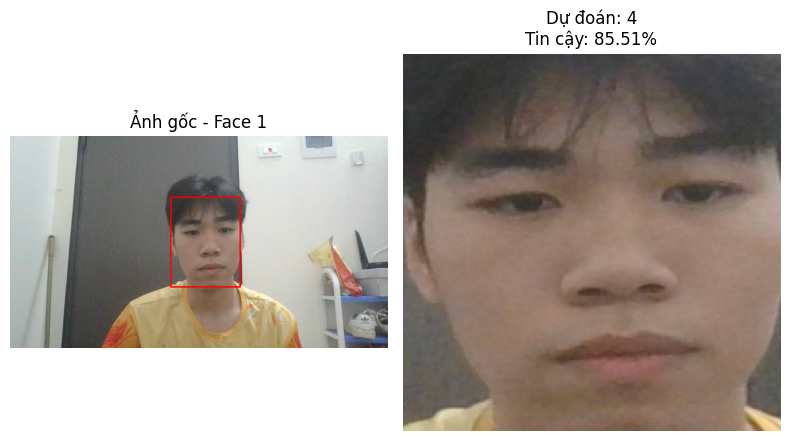

Face 1: 4 (Confidence: 85.51%)


In [36]:
# DỰ ĐOÁN ẢNH - FIXED VERSION
from google.colab import files
import matplotlib.pyplot as plt

# Upload ảnh để test
print("Upload ảnh để test...")
uploaded = files.upload()

for fn in uploaded.keys():
    test_path = fn
    print(f"\nĐang test ảnh: {fn}")

    # Đọc ảnh
    img = cv2.imread(test_path)
    if img is None:
        print("Không thể đọc ảnh")
        continue

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Detect mặt bằng MTCNN
    results = detector.detect_faces(img_rgb)

    if len(results) == 0:
        print("Không tìm thấy khuôn mặt")
        # Hiển thị ảnh gốc
        plt.figure(figsize=(8, 6))
        plt.imshow(img_rgb)
        plt.axis("off")
        plt.title("Không detect được face")
        plt.show()
        continue

    print(f"Tìm thấy {len(results)} khuôn mặt")

    # Xử lý tất cả faces trong ảnh
    for i, result in enumerate(results):
        x, y, w, h = result['box']
        x, y = max(0, x), max(0, y)

        # Crop face
        face = img_rgb[y:y+h, x:x+w]

        # Resize về 224x224
        face_resized = cv2.resize(face, (224, 224))

        # Preprocess cho ResNet50
        face_prep = preprocess_input(face_resized.astype(np.float32))
        face_prep = np.expand_dims(face_prep, axis=0)

        # Trích xuất đặc trưng bằng ResNet50
        feat = resnet_model.predict(face_prep, verbose=0)
        feat_flat = feat.flatten().reshape(1, -1)

        # Normalize features
        feat_norm = normalize(feat_flat, norm='l2')

        # Dự đoán với SVM
        pred_label = svm_classifier.predict(feat_norm)[0]
        pred_prob = svm_classifier.predict_proba(feat_norm).max() * 100

        # Hiển thị kết quả
        plt.figure(figsize=(8, 6))

        # Subplot 1: Ảnh gốc với bounding box
        plt.subplot(1, 2, 1)
        img_with_box = img_rgb.copy()
        cv2.rectangle(img_with_box, (x, y), (x+w, y+h), (255, 0, 0), 3)
        plt.imshow(img_with_box)
        plt.axis("off")
        plt.title(f"Ảnh gốc - Face {i+1}")

        # Subplot 2: Face đã crop
        plt.subplot(1, 2, 2)
        plt.imshow(face_resized)
        plt.axis("off")
        plt.title(f"Dự đoán: {pred_label}\nTin cậy: {pred_prob:.2f}%")

        plt.tight_layout()
        plt.show()

        print(f"Face {i+1}: {pred_label} (Confidence: {pred_prob:.2f}%)")
